In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal
from scipy import optimize
from google_drive_downloader import GoogleDriveDownloader as gdd
import os
import time as timemodule
import sys
import datetime

In [2]:
washing_predicted = np.load("data/washing predicted.npy")
dryers_predicted = np.load("data/drying predicted.npy")
temperature, rains = np.load("temp and rain.npy", allow_pickle=True)

In [3]:
def formating(x, precision=4):
    if type(x) == str:
        return x
    else:
        return str(x)[0:precision]
def predict_use(day = None, 
                minute = None, 
                hour = None, 
                temp = None, 
                rain = None, 
                dt=45, 
                Wcorrection=0, 
                Dcorrection=0, 
                handle_nan=True):
    
    day_list = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
    time_array = np.arange(0, 24*60-1, 1).astype(np.int)
    
    if day == None:
        day = day_list[(datetime.date.today()).weekday()]
    if hour == None and minute == None:
        hour = datetime.datetime.now().hour
        minute = datetime.datetime.now().minute
        print("Today is %s. The time is %02d:%02d."%(day, hour, minute))
    elif minute == None:
        minute=0
        if dt < 60:
            dt=60
    if type(day) == str:
        i = day_list.index(day)
    elif type(day) is int:
        i = day
    else:
        raise ValueError("Day must be integer or weekday")
    j = int(hour*60+minute)
    
    if rain == None and temp == None:
        mean_washing = np.nanmean(washing_predicted[i, j:j+dt, ::,::])
        mean_drying = np.nanmean(dryers_predicted[i:i+dt, j:j+dt, ::,::])
    elif rain==None:
        k = np.where(temperature==temp)
        mean_washing = np.nanmean(washing_predicted[i, j:j+dt, k,::])
        mean_drying = np.nanmean(dryers_predicted[i:i+dt, j:j+dt, k,::])
    elif temp==None:
        l = np.where(rains==rain)
        mean_washing = np.nanmean(washing_predicted[i, j:j+dt, ::,l])
        mean_drying = np.nanmean(dryers_predicted[i:i+dt, j:j+dt, ::,l])
    else:
        k = np.where(temperature==temp)
        l = np.where(rains==rain)
        mean_washing = np.nanmean(washing_predicted[i, j:j+dt, k,l])
        mean_drying = np.nanmean(dryers_predicted[i:i+dt, j:j+dt, k,l])
    
    if handle_nan == True:
        if np.isnan(mean_washing):
            mean_washing = "Not enough data available"
        if np.isnan(mean_drying):
            mean_drying = "Not enough data available"
    return mean_washing-Wcorrection, mean_drying-Dcorrection

In [5]:
use = predict_use()

print("Expectation values of machine use:\nWashing machines: %s\nDryers: %s"%(formating(use[0]), formating(use[1])))

Today is Saturday. The time is 18:30.
Expectation values of machine use:
Washing machines: 3.12
Dryers: 4.42


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: Mean of empty slice
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: Mean of empty slice


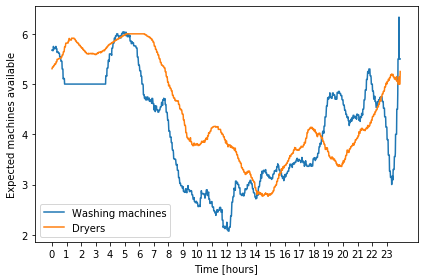

In [7]:
time_array = np.arange(0, 24*60-1, 1).astype(np.int)
day =None

washers = np.zeros(time_array.size)
dryers = np.zeros(time_array.size)

for t in time_array:
    washers[t], dryers[t] = predict_use(day=day, hour=np.floor(t/60),minute=t%60, handle_nan=False, dt=90)

plt.plot(time_array/60, washers, label="Washing machines")
plt.plot(time_array/60, dryers, label="Dryers")
plt.xlabel("Time [hours]")
plt.ylabel("Expected machines available")
plt.xticks(np.arange(0,24))
plt.legend()
plt.tight_layout()
plt.show()